## Victor Gómez
### victor.gomez@cimat.mx


# Maestría en Cómputo Estadístico
# CIMAT Monterrey

# <center>Tópicos selectos de Cómputo<center>
# <center>Tarea 1: Valores faltantes<center>

Instrucciones: 
- Usa python 3.x , tensorflow 2.x y xgboost 1.x
- ejecuta todas las celdas para replicar los resultados

In [45]:
#Librerías necesarias
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import  cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer

# Clase que realiza la imputación de datos faltantes en un DataFrame por distintos métodos.

## Métodos de imputación de valores faltantes:

- 1 Métodos no estadísticos: LOCF (Last observation carried forward)
- 2 Métodos estadísticos:    mean_mode (media para atributos numéricos, moda para atributos categoricos)

Métodos de Machine Learning: 
- 3 Vecinos mas cercanos: knn (KNeighbors: k: 10)
- 4 Arboles de decisión:  trees (XGBoost: learning rate: 0.3, n_estimators: 150, subsample: 0.9, regularización: gamma: 10, lambda: 10)
- 5 Redes neuronales:     MLP (epocas: 100, optimizador: adam, función de costo: binary_crossentropy(o categorical_crossentropy), metrica: accuracy, hiddenlayers:  2 con 50 neuronas, función de activación: relu. outputlayer: función de activación: sigmoid (o softmax) con 1 (o número de clases) neuronas.)

In [ ]:
from _missing_value import MissingValueImputation #Clase que realiza la imputacion de datos faltantes en un DataFrame por distintos metodos

## Conjuntos de datos con valores faltantes (%MVs):
datasets de: https://sci2s.ugr.es/keel/missing.php

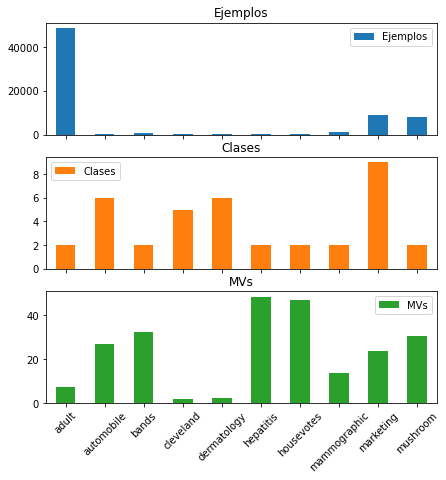

In [29]:
names=['adult','automobile','bands','cleveland','dermatology','hepatitis','housevotes','mammographic','marketing','mushroom']
Ejemplos=[48842,205,539,303,366,155,435,961,8993,8124]
clases=[2,6,2,5,6,2,2,2,9,2]
mvs=[7.41,26.83,32.28,1.98,2.19,48.39,46.67,13.63,23.54,30.53]

df_mvs_dict={
            'Ejemplos': Ejemplos,
             'Clases': clases,
             'MVs': mvs}

df_mvs=pd.DataFrame(df_mvs_dict)
df_mvs.index=names

axes = df_mvs.plot.bar(rot=45, subplots=True,figsize=(7,7))
axes[1].legend(loc=2)  

Los 10 conjuntos de datos presentan diferentes características, 3 contienen mucha mayor cantidad de ejemplos que  los demás, además que algunos tienen mayor cantidad de porcentaje de datos faltantes que otros.

## Modelos de ML para clasificación con validación cruzada 5-Fold y metrica accuracy:

- 1 KNeighbors: k: 10
- 2 XGBoost: learning rate: 0.3, n_estimators: 150, subsample: 0.9, regularización: gamma: 10,lambda: 10
- 3 MLP, epocas: 100, optimizador: adam, función de costo: binary_crossentropy(o categorical_crossentropy), hiddenlayers:  2 con 50 neuronas, función de activación: relu. outputlayer: función de activación: sigmoid (o softmax) con 1 (o número de clases) neuronas. 


In [2]:
def df_clean(df): #libera memoria
    df=pd.DataFrame()
    del df
    
#Models:
#K Neighbors
def KNN_model():
    return KNeighborsClassifier(n_neighbors=10)

#XGBoost
def XGBoost_model(num_classes=2):
    
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier(learning_rate=0.3,n_estimators=150,subsample=0.9,gamma=10,reg_lambda=10,n_jobs=-1)
                
    else:
        gbm=xgb.XGBClassifier(objective='multi:softmax',learning_rate=0.3,n_estimators=150,subsample=0.9,gamma=10,reg_lambda=10,n_jobs=-1)
    
    return gbm 



#MLP
def create_model(input_features,neurons_output,activation,loss):
    neur_Hid_layer=[50,50]
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neur_Hid_layer[0],activation='relu',input_shape=(input_features,))) #first layer
    model.add(tf.keras.layers.BatchNormalization()) #batch normalization
        
    layers=len(neur_Hid_layer)
        
    if layers>1: #next hidden layers
        for layer in range(1,layers):
            model.add(tf.keras.layers.Dense(neur_Hid_layer[layer],activation='relu'))
            model.add(tf.keras.layers.BatchNormalization()) #batch normalization
        
    if activation!='linear':
        model.add(tf.keras.layers.Dense(neurons_output,activation=activation)) #output layer
    else:
        model.add(tf.keras.layers.Dense(neurons_output)) #output layer
    
    
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy']) #compìla el modelo
        
    return model


#Cross validation 
def model_train_CV_(model,X_train,y_train,cv=5): 
    kfold=cross_val_score(model,X_train,y_train,cv=cv,n_jobs=-1)
    score=kfold.mean()
    return score

#prepara los datos, entrena, y obtiene scores para cada modelo
def Data_Prer_Mod_train(df,model_name,cv): 
    _,column=df.shape
    column=column-1
    flat= lambda x,num_features: x.reshape([-1, num_features]) # Flatten function
    if model_name=='KNN':
        y=df.iloc[:,column].values
        X=pd.get_dummies(df.drop([column],axis=1),drop_first=True).values
        model=KNN_model()
        score=model_train_CV_(model,X,y,cv)
        
    elif model_name=='XGB':
        y=df.iloc[:,column].values
        X=pd.get_dummies(df.drop([column],axis=1),drop_first=True).values
        num_classes=np.shape(df.iloc[:,column].unique())[0]
        model=XGBoost_model(num_classes)
        score=model_train_CV_(model,X,y,cv)
    elif model_name=='MLP':
        y=df.iloc[:,column].values
        X=pd.get_dummies(df.drop([column],axis=1),drop_first=True).values
        num_classes=np.shape(df.iloc[:,column].unique())[0]
        num_features=X.shape[1]
        scaler = StandardScaler() #Standardize
        scaler.fit(X)
        X=scaler.transform(X)
        X=flat(X,num_features) #flatten
        
        if num_classes==2:
            y=np.reshape(y,(-1, 1))
            enc=OneHotEncoder(drop='first').fit(y)
            y = enc.transform(y).toarray()
            lossf='binary_crossentropy'
            activ_output='sigmoid'
            neurons_output=1
            
        else:
            y=np.reshape(y,(-1, 1))
            enc=OneHotEncoder().fit(y)
            y = enc.transform(y).toarray()
            lossf='categorical_crossentropy'
            activ_output='softmax'
            neurons_output=num_classes
        
        model=KerasClassifier(build_fn=create_model, epochs=100,  input_features=num_features,neurons_output=neurons_output,activation=activ_output,loss=lossf)

        kfold=cross_val_score(model,X,y,cv=cv,n_jobs=-1)
        score=kfold.mean()
        
    return np.round(score,2)

# 1.- Importación de los conjuntos de datos, Imputación de los datos faltantes, Ajuste de modelos y Validacion cruzada 5-Fold.

In [3]:
startTime = datetime.now()
#importa los conjuntos de datos
names=['automobile','bands','cleveland','dermatology','hepatitis','housevotes','mammographic','marketing','mushroom','adult']
methods=['LOCF','mean_mode','knn','trees','MLP']
models=['KNN','XGB','MLP']
results_LOCF=[]
results_mean_mode=[]
results_knn=[]
results_trees=[]
results_MLP=[]
for name in names: #abre los conjuntos de datos
    DataFrame = pd.read_csv(name+'.csv', header=None, na_values=[' ','  ','?',None])
    for method in methods: # imputa datos faltantes con cada metodo
        df_complete_i = MissingValueImputation(method = method).fit_transform(DataFrame)
        for model in models: #ajusta modelos de Machine Learning
            result=Data_Prer_Mod_train(df_complete_i,model,5)
            #imprime y guarda resultados
            print('DataFrame: '+name+' imput_method :'+method+' model :'+model+' score: ',result)
            if method=='LOCF':
                results_LOCF.append(result)
            elif method=='mean_mode':
                results_mean_mode.append(result)
            elif method=='knn':
                results_knn.append(result)
            elif method=='trees':
                results_trees.append(result)
            elif method=='MLP':
                results_MLP.append(result)
        df_clean(df_complete_i) #libera memoria
    df_clean(DataFrame) #libera memoria
print(datetime.now() - startTime) #tiempo total

C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: automobile imput_method :LOCF model :KNN score:  0.38


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: automobile imput_method :LOCF model :XGB score:  0.5
DataFrame: automobile imput_method :LOCF model :MLP score:  0.76


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: automobile imput_method :mean_mode model :KNN score:  0.38


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: automobile imput_method :mean_mode model :XGB score:  0.48
DataFrame: automobile imput_method :mean_mode model :MLP score:  0.74


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: automobile imput_method :knn model :KNN score:  0.39
DataFrame: automobile imput_method :knn model :XGB score:  0.48
DataFrame: automobile imput_method :knn model :MLP score:  0.78
[0]	validation_0-mae:87.38394
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:63.14961
[2]	validation_0-mae:46.67097
[3]	validation_0-mae:35.23204
[4]	validation_0-mae:27.69285
[5]	validation_0-mae:22.26601
[6]	validation_0-mae:18.56758
[7]	validation_0-mae:15.52041
[8]	validation_0-mae:13.31204
[9]	validation_0-mae:11.25003
[10]	validation_0-mae:9.90334
[11]	validation_0-mae:8.75421
[12]	validation_0-mae:7.89097
[13]	validation_0-mae:7.20449
[14]	validation_0-mae:6.55076
[15]	validation_0-mae:5.99387
[16]	validation_0-mae:5.42914
[17]	validation_0-mae:4.98692
[18]	validation_0-mae:4.65623
[19]	validation_0-mae:4.26929
[20]	validation_0-mae:4.01351
[21]	validation_0-mae:3.75540
[22]	validation_0-mae:3.50051
[23]	validation_0-mae:3.31703
[24]	validation_0-mae:3.1

[36]	validation_0-mae:17.12335
[37]	validation_0-mae:16.45349
[38]	validation_0-mae:15.26633
[39]	validation_0-mae:14.72631
[40]	validation_0-mae:14.00850
[41]	validation_0-mae:13.39026
[42]	validation_0-mae:12.66663
[43]	validation_0-mae:12.19048
[44]	validation_0-mae:11.75091
[45]	validation_0-mae:11.22744
[46]	validation_0-mae:10.82458
[47]	validation_0-mae:10.42368
[48]	validation_0-mae:9.91040
[49]	validation_0-mae:9.62536
[50]	validation_0-mae:9.35010
[51]	validation_0-mae:8.97877
[52]	validation_0-mae:8.50780
[53]	validation_0-mae:8.19062
[54]	validation_0-mae:7.94886
[55]	validation_0-mae:7.68018
[56]	validation_0-mae:7.37758
[57]	validation_0-mae:7.11895
[58]	validation_0-mae:6.90014
[59]	validation_0-mae:6.75735
[60]	validation_0-mae:6.49760
[61]	validation_0-mae:6.29545
[62]	validation_0-mae:6.12745
[63]	validation_0-mae:5.99685
[64]	validation_0-mae:5.77244
[65]	validation_0-mae:5.64287
[66]	validation_0-mae:5.44337
[67]	validation_0-mae:5.13114
[68]	validation_0-mae:5.0288

C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: automobile imput_method :trees model :XGB score:  0.49
DataFrame: automobile imput_method :trees model :MLP score:  0.77
Train on 159 samples, validate on 159 samples
Epoch 1/100
159/159 [==============================] - 1s 5ms/sample - loss: 121.1160 - mae: 121.1160 - val_loss: 121.3785 - val_mae: 121.3784
Epoch 2/100
159/159 [==============================] - 0s 145us/sample - loss: 121.0741 - mae: 121.0741 - val_loss: 121.3102 - val_mae: 121.3102
Epoch 3/100
159/159 [==============================] - 0s 145us/sample - loss: 121.0295 - mae: 121.0295 - val_loss: 121.2399 - val_mae: 121.2399
Epoch 4/100
159/159 [==============================] - 0s 132us/sample - loss: 120.9818 - mae: 120.9818 - val_loss: 121.1661 - val_mae: 121.1661
Epoch 5/100
159/159 [==============================] - 0s 151us/sample - loss: 120.9306 - mae: 120.9306 - val_loss: 121.0905 - val_mae: 121.0905
Epoch 6/100
159/159 [==============================] - 0s 138us/sample - loss: 120.8756 - mae: 120.

Epoch 56/100
159/159 [==============================] - 0s 138us/sample - loss: 110.5501 - mae: 110.5501 - val_loss: 110.1342 - val_mae: 110.1342
Epoch 57/100
159/159 [==============================] - 0s 145us/sample - loss: 110.1776 - mae: 110.1776 - val_loss: 109.7673 - val_mae: 109.7673
Epoch 58/100
159/159 [==============================] - 0s 145us/sample - loss: 109.7986 - mae: 109.7986 - val_loss: 109.3844 - val_mae: 109.3844
Epoch 59/100
159/159 [==============================] - 0s 151us/sample - loss: 109.4130 - mae: 109.4130 - val_loss: 108.9889 - val_mae: 108.9889
Epoch 60/100
159/159 [==============================] - 0s 138us/sample - loss: 109.0209 - mae: 109.0209 - val_loss: 108.5937 - val_mae: 108.5937
Epoch 61/100
159/159 [==============================] - 0s 145us/sample - loss: 108.6223 - mae: 108.6223 - val_loss: 108.1933 - val_mae: 108.1933
Epoch 62/100
159/159 [==============================] - 0s 145us/sample - loss: 108.2171 - mae: 108.2171 - val_loss: 107.781

159/159 [==============================] - 0s 145us/sample - loss: 1.1425 - mae: 1.1425 - val_loss: 0.6923 - val_mae: 0.6923
Epoch 27/100
159/159 [==============================] - 0s 151us/sample - loss: 1.0252 - mae: 1.0252 - val_loss: 0.5969 - val_mae: 0.5969
Epoch 28/100
159/159 [==============================] - 0s 145us/sample - loss: 0.9189 - mae: 0.9189 - val_loss: 0.5118 - val_mae: 0.5118
Epoch 29/100
159/159 [==============================] - 0s 132us/sample - loss: 0.8187 - mae: 0.8187 - val_loss: 0.4255 - val_mae: 0.4255
Epoch 30/100
159/159 [==============================] - 0s 147us/sample - loss: 0.7005 - mae: 0.7005 - val_loss: 0.3964 - val_mae: 0.3964
Epoch 31/100
159/159 [==============================] - 0s 138us/sample - loss: 0.6148 - mae: 0.6148 - val_loss: 0.3514 - val_mae: 0.3514
Epoch 32/100
159/159 [==============================] - 0s 134us/sample - loss: 0.5887 - mae: 0.5887 - val_loss: 0.3498 - val_mae: 0.3498
Epoch 33/100
159/159 [=========================

159/159 [==============================] - 0s 145us/sample - loss: 88.2559 - mae: 88.2559 - val_loss: 87.8564 - val_mae: 87.8564
Epoch 48/100
159/159 [==============================] - 0s 145us/sample - loss: 87.9414 - mae: 87.9414 - val_loss: 87.5456 - val_mae: 87.5456
Epoch 49/100
159/159 [==============================] - 0s 141us/sample - loss: 87.6204 - mae: 87.6204 - val_loss: 87.2397 - val_mae: 87.2397
Epoch 50/100
159/159 [==============================] - 0s 138us/sample - loss: 87.2927 - mae: 87.2927 - val_loss: 86.9278 - val_mae: 86.9278
Epoch 51/100
159/159 [==============================] - 0s 138us/sample - loss: 86.9585 - mae: 86.9585 - val_loss: 86.5997 - val_mae: 86.5997
Epoch 52/100
159/159 [==============================] - 0s 141us/sample - loss: 86.6177 - mae: 86.6177 - val_loss: 86.2600 - val_mae: 86.2600
Epoch 53/100
159/159 [==============================] - 0s 139us/sample - loss: 86.2703 - mae: 86.2703 - val_loss: 85.9129 - val_mae: 85.9129
Epoch 54/100
159/15

Epoch 58/100
159/159 [==============================] - 0s 145us/sample - loss: 5102.0386 - mae: 5102.0391 - val_loss: 5101.7742 - val_mae: 5101.7739
Epoch 59/100
159/159 [==============================] - 0s 138us/sample - loss: 5101.6484 - mae: 5101.6484 - val_loss: 5101.3874 - val_mae: 5101.3872
Epoch 60/100
159/159 [==============================] - 0s 145us/sample - loss: 5101.2519 - mae: 5101.2515 - val_loss: 5100.9892 - val_mae: 5100.9893
Epoch 61/100
159/159 [==============================] - 0s 142us/sample - loss: 5100.8489 - mae: 5100.8491 - val_loss: 5100.5870 - val_mae: 5100.5874
Epoch 62/100
159/159 [==============================] - 0s 145us/sample - loss: 5100.4393 - mae: 5100.4395 - val_loss: 5100.1624 - val_mae: 5100.1621
Epoch 63/100
159/159 [==============================] - 0s 132us/sample - loss: 5100.0234 - mae: 5100.0229 - val_loss: 5099.7379 - val_mae: 5099.7378
Epoch 64/100
159/159 [==============================] - 0s 163us/sample - loss: 5099.6011 - mae: 509

159/159 [==============================] - 0s 138us/sample - loss: 11431.7710 - mae: 11431.7705 - val_loss: 11431.5620 - val_mae: 11431.5615
Epoch 65/100
159/159 [==============================] - 0s 151us/sample - loss: 11431.3441 - mae: 11431.3447 - val_loss: 11431.1366 - val_mae: 11431.1367
Epoch 66/100
159/159 [==============================] - 0s 146us/sample - loss: 11430.9110 - mae: 11430.9121 - val_loss: 11430.6994 - val_mae: 11430.6992
Epoch 67/100
159/159 [==============================] - 0s 151us/sample - loss: 11430.4711 - mae: 11430.4707 - val_loss: 11430.2650 - val_mae: 11430.2656
Epoch 68/100
159/159 [==============================] - 0s 145us/sample - loss: 11430.0251 - mae: 11430.0254 - val_loss: 11429.8280 - val_mae: 11429.8281
Epoch 69/100
159/159 [==============================] - 0s 145us/sample - loss: 11429.5718 - mae: 11429.5713 - val_loss: 11429.3783 - val_mae: 11429.3789
Epoch 70/100
159/159 [==============================] - 0s 139us/sample - loss: 11429.112

C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: automobile imput_method :MLP model :XGB score:  0.49
DataFrame: automobile imput_method :MLP model :MLP score:  0.73
DataFrame: bands imput_method :LOCF model :KNN score:  0.58
DataFrame: bands imput_method :LOCF model :XGB score:  0.53
DataFrame: bands imput_method :LOCF model :MLP score:  0.51
DataFrame: bands imput_method :mean_mode model :KNN score:  0.57
DataFrame: bands imput_method :mean_mode model :XGB score:  0.55
DataFrame: bands imput_method :mean_mode model :MLP score:  0.52
DataFrame: bands imput_method :knn model :KNN score:  0.57
DataFrame: bands imput_method :knn model :XGB score:  0.58
DataFrame: bands imput_method :knn model :MLP score:  0.52
[0]	validation_0-mae:31.50691
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:22.23046
[2]	validation_0-mae:15.89912
[3]	validation_0-mae:11.80451
[4]	validation_0-mae:9.14674
[5]	validation_0-mae:7.45403
[6]	validation_0-mae:6.23692
[7]	validation_0-mae:5.41807
[8]	validation_0-mae:

[52]	validation_0-mae:1.35716
[53]	validation_0-mae:1.33163
[54]	validation_0-mae:1.30167
[55]	validation_0-mae:1.29095
[56]	validation_0-mae:1.27911
[57]	validation_0-mae:1.26255
[58]	validation_0-mae:1.26254
[59]	validation_0-mae:1.25609
[60]	validation_0-mae:1.23512
[61]	validation_0-mae:1.23521
[62]	validation_0-mae:1.22878
[63]	validation_0-mae:1.22151
[64]	validation_0-mae:1.22136
[65]	validation_0-mae:1.20681
[66]	validation_0-mae:1.20115
[67]	validation_0-mae:1.20118
[68]	validation_0-mae:1.20115
[69]	validation_0-mae:1.19670
[70]	validation_0-mae:1.18127
[71]	validation_0-mae:1.17596
[72]	validation_0-mae:1.17596
[73]	validation_0-mae:1.17596
Stopping. Best iteration:
[71]	validation_0-mae:1.17596

[0]	validation_0-mae:0.20806
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:0.17753
[2]	validation_0-mae:0.16366
[3]	validation_0-mae:0.15756
[4]	validation_0-mae:0.15344
[5]	validation_0-mae:0.15025
[6]	validation_0-mae:0.14808
[7]	validation_0-

[142]	validation_0-mae:2.57165
[143]	validation_0-mae:2.51906
[144]	validation_0-mae:2.47987
[145]	validation_0-mae:2.42111
[146]	validation_0-mae:2.34404
[147]	validation_0-mae:2.29670
[148]	validation_0-mae:2.28016
[149]	validation_0-mae:2.24796
[0]	validation_0-mae:38.97459
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:27.55362
[2]	validation_0-mae:19.58620
[3]	validation_0-mae:13.94943
[4]	validation_0-mae:9.99901
[5]	validation_0-mae:7.18935
[6]	validation_0-mae:5.22799
[7]	validation_0-mae:3.83829
[8]	validation_0-mae:2.84407
[9]	validation_0-mae:2.13704
[10]	validation_0-mae:1.65585
[11]	validation_0-mae:1.29336
[12]	validation_0-mae:1.04364
[13]	validation_0-mae:0.86862
[14]	validation_0-mae:0.74101
[15]	validation_0-mae:0.67564
[16]	validation_0-mae:0.63425
[17]	validation_0-mae:0.58019
[18]	validation_0-mae:0.52449
[19]	validation_0-mae:0.51414
[20]	validation_0-mae:0.50506
[21]	validation_0-mae:0.49666
[22]	validation_0-mae:0.48756
[23]	

[15]	validation_0-mae:0.86401
[16]	validation_0-mae:0.79721
[17]	validation_0-mae:0.78331
[18]	validation_0-mae:0.75056
[19]	validation_0-mae:0.72052
[20]	validation_0-mae:0.71006
[21]	validation_0-mae:0.70925
[22]	validation_0-mae:0.70781
[23]	validation_0-mae:0.70307
[24]	validation_0-mae:0.69722
[25]	validation_0-mae:0.69714
[26]	validation_0-mae:0.69323
[27]	validation_0-mae:0.69321
[28]	validation_0-mae:0.69309
[29]	validation_0-mae:0.69312
[30]	validation_0-mae:0.69086
[31]	validation_0-mae:0.69104
[32]	validation_0-mae:0.69095
Stopping. Best iteration:
[30]	validation_0-mae:0.69086

[0]	validation_0-mae:72.40811
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:51.11698
[2]	validation_0-mae:36.09253
[3]	validation_0-mae:25.49885
[4]	validation_0-mae:18.03033
[5]	validation_0-mae:12.77881
[6]	validation_0-mae:9.17167
[7]	validation_0-mae:6.72905
[8]	validation_0-mae:5.28773
[9]	validation_0-mae:4.36414
[10]	validation_0-mae:3.83503
[11]	validatio

Epoch 14/100
365/365 [==============================] - 0s 114us/sample - loss: 46.7740 - mae: 46.7740 - val_loss: 46.4982 - val_mae: 46.4982
Epoch 15/100
365/365 [==============================] - 0s 115us/sample - loss: 46.2255 - mae: 46.2255 - val_loss: 45.9551 - val_mae: 45.9550
Epoch 16/100
365/365 [==============================] - 0s 110us/sample - loss: 45.6396 - mae: 45.6396 - val_loss: 45.3647 - val_mae: 45.3647
Epoch 17/100
365/365 [==============================] - 0s 116us/sample - loss: 45.0162 - mae: 45.0162 - val_loss: 44.7364 - val_mae: 44.7364
Epoch 18/100
365/365 [==============================] - 0s 119us/sample - loss: 44.3552 - mae: 44.3552 - val_loss: 44.0751 - val_mae: 44.0751
Epoch 19/100
365/365 [==============================] - 0s 112us/sample - loss: 43.6566 - mae: 43.6566 - val_loss: 43.3647 - val_mae: 43.3647
Epoch 20/100
365/365 [==============================] - 0s 113us/sample - loss: 42.9202 - mae: 42.9202 - val_loss: 42.6155 - val_mae: 42.6155
Epoch 

Epoch 39/100
365/365 [==============================] - 0s 122us/sample - loss: 0.8282 - mae: 0.8282 - val_loss: 0.6624 - val_mae: 0.6624
Epoch 40/100
365/365 [==============================] - 0s 110us/sample - loss: 0.8491 - mae: 0.8491 - val_loss: 0.5882 - val_mae: 0.5882
Epoch 41/100
365/365 [==============================] - 0s 104us/sample - loss: 0.8636 - mae: 0.8636 - val_loss: 0.5520 - val_mae: 0.5520
Epoch 42/100
365/365 [==============================] - 0s 110us/sample - loss: 0.8079 - mae: 0.8079 - val_loss: 0.5817 - val_mae: 0.5817
Epoch 43/100
365/365 [==============================] - 0s 37us/sample - loss: 0.5690 - mae: 0.5690
Val score is 0.5690214037895203
Train on 365 samples, validate on 365 samples
Epoch 1/100
365/365 [==============================] - 1s 2ms/sample - loss: 78.6310 - mae: 78.6310 - val_loss: 78.4216 - val_mae: 78.4216
Epoch 2/100
365/365 [==============================] - 0s 115us/sample - loss: 78.4965 - mae: 78.4965 - val_loss: 78.2884 - val_mae

Epoch 53/100
365/365 [==============================] - 0s 112us/sample - loss: 25.7115 - mae: 25.7115 - val_loss: 23.6481 - val_mae: 23.6481
Epoch 54/100
365/365 [==============================] - 0s 120us/sample - loss: 23.8430 - mae: 23.8430 - val_loss: 21.5954 - val_mae: 21.5954
Epoch 55/100
365/365 [==============================] - 0s 113us/sample - loss: 21.8498 - mae: 21.8498 - val_loss: 18.9540 - val_mae: 18.9540
Epoch 56/100
365/365 [==============================] - 0s 112us/sample - loss: 19.8765 - mae: 19.8764 - val_loss: 16.5572 - val_mae: 16.5572
Epoch 57/100
365/365 [==============================] - 0s 108us/sample - loss: 17.8570 - mae: 17.8570 - val_loss: 14.2506 - val_mae: 14.2506
Epoch 58/100
365/365 [==============================] - 0s 113us/sample - loss: 15.8003 - mae: 15.8003 - val_loss: 12.2259 - val_mae: 12.2259
Epoch 59/100
365/365 [==============================] - 0s 110us/sample - loss: 13.8375 - mae: 13.8375 - val_loss: 10.4025 - val_mae: 10.4025
Epoch 

365/365 [==============================] - 0s 36us/sample - loss: 0.1136 - mae: 0.1136
Val score is 0.11359177529811859
Train on 365 samples, validate on 365 samples
Epoch 1/100
365/365 [==============================] - 1s 2ms/sample - loss: 30.8458 - mae: 30.8458 - val_loss: 30.3390 - val_mae: 30.3390
Epoch 2/100
365/365 [==============================] - 0s 114us/sample - loss: 30.7330 - mae: 30.7330 - val_loss: 30.2698 - val_mae: 30.2698
Epoch 3/100
365/365 [==============================] - 0s 110us/sample - loss: 30.5999 - mae: 30.5999 - val_loss: 30.1776 - val_mae: 30.1776
Epoch 4/100
365/365 [==============================] - 0s 118us/sample - loss: 30.4421 - mae: 30.4421 - val_loss: 30.0575 - val_mae: 30.0575
Epoch 5/100
365/365 [==============================] - 0s 111us/sample - loss: 30.2560 - mae: 30.2560 - val_loss: 29.9058 - val_mae: 29.9058
Epoch 6/100
365/365 [==============================] - 0s 118us/sample - loss: 30.0389 - mae: 30.0389 - val_loss: 29.7180 - val_mae

Epoch 16/100
365/365 [==============================] - 0s 134us/sample - loss: 1846.0571 - mae: 1846.0570 - val_loss: 1845.2836 - val_mae: 1845.2836
Epoch 17/100
365/365 [==============================] - 0s 109us/sample - loss: 1845.4337 - mae: 1845.4337 - val_loss: 1844.6147 - val_mae: 1844.6145
Epoch 18/100
365/365 [==============================] - 0s 110us/sample - loss: 1844.7726 - mae: 1844.7726 - val_loss: 1843.9223 - val_mae: 1843.9222
Epoch 19/100
365/365 [==============================] - 0s 112us/sample - loss: 1844.0739 - mae: 1844.0739 - val_loss: 1843.1902 - val_mae: 1843.1901
Epoch 20/100
365/365 [==============================] - 0s 112us/sample - loss: 1843.3373 - mae: 1843.3372 - val_loss: 1842.4252 - val_mae: 1842.4252
Epoch 21/100
365/365 [==============================] - 0s 116us/sample - loss: 1842.5630 - mae: 1842.5629 - val_loss: 1841.6155 - val_mae: 1841.6157
Epoch 22/100
365/365 [==============================] - 0s 115us/sample - loss: 1841.7619 - mae: 184

Epoch 25/100
365/365 [==============================] - 0s 111us/sample - loss: 43.3253 - mae: 43.3253 - val_loss: 43.0883 - val_mae: 43.0883
Epoch 26/100
365/365 [==============================] - 0s 114us/sample - loss: 42.3574 - mae: 42.3574 - val_loss: 42.1060 - val_mae: 42.1060
Epoch 27/100
365/365 [==============================] - 0s 144us/sample - loss: 41.3523 - mae: 41.3523 - val_loss: 41.0867 - val_mae: 41.0867
Epoch 28/100
365/365 [==============================] - 0s 110us/sample - loss: 40.3102 - mae: 40.3102 - val_loss: 40.0329 - val_mae: 40.0329
Epoch 29/100
365/365 [==============================] - 0s 112us/sample - loss: 39.2310 - mae: 39.2310 - val_loss: 38.9183 - val_mae: 38.9183
Epoch 30/100
365/365 [==============================] - 0s 109us/sample - loss: 38.1150 - mae: 38.1150 - val_loss: 37.7689 - val_mae: 37.7689
Epoch 31/100
365/365 [==============================] - 0s 120us/sample - loss: 36.9623 - mae: 36.9623 - val_loss: 36.5857 - val_mae: 36.5857
Epoch 

365/365 [==============================] - 0s 126us/sample - loss: 1.6208 - mae: 1.6208 - val_loss: 1.5625 - val_mae: 1.5625
Epoch 6/100
365/365 [==============================] - 0s 110us/sample - loss: 1.5767 - mae: 1.5767 - val_loss: 1.5534 - val_mae: 1.5534
Epoch 7/100
365/365 [==============================] - 0s 112us/sample - loss: 1.5604 - mae: 1.5604 - val_loss: 1.5423 - val_mae: 1.5423
Epoch 8/100
365/365 [==============================] - 0s 110us/sample - loss: 1.5167 - mae: 1.5167 - val_loss: 1.5341 - val_mae: 1.5341
Epoch 9/100
365/365 [==============================] - 0s 115us/sample - loss: 1.5088 - mae: 1.5088 - val_loss: 1.5224 - val_mae: 1.5224
Epoch 10/100
365/365 [==============================] - 0s 114us/sample - loss: 1.4844 - mae: 1.4844 - val_loss: 1.5078 - val_mae: 1.5078
Epoch 11/100
365/365 [==============================] - 0s 113us/sample - loss: 1.4598 - mae: 1.4598 - val_loss: 1.4935 - val_mae: 1.4935
Epoch 12/100
365/365 [=============================

365/365 [==============================] - 0s 106us/sample - loss: 26.4587 - mae: 26.4587 - val_loss: 26.6241 - val_mae: 26.6241
Epoch 21/100
365/365 [==============================] - 0s 112us/sample - loss: 25.6772 - mae: 25.6772 - val_loss: 25.8667 - val_mae: 25.8667
Epoch 22/100
365/365 [==============================] - 0s 115us/sample - loss: 24.8582 - mae: 24.8582 - val_loss: 25.0328 - val_mae: 25.0328
Epoch 23/100
365/365 [==============================] - 0s 109us/sample - loss: 24.0019 - mae: 24.0019 - val_loss: 24.1493 - val_mae: 24.1493
Epoch 24/100
365/365 [==============================] - 0s 115us/sample - loss: 23.1082 - mae: 23.1082 - val_loss: 23.2198 - val_mae: 23.2198
Epoch 25/100
365/365 [==============================] - 0s 123us/sample - loss: 22.1772 - mae: 22.1772 - val_loss: 22.2374 - val_mae: 22.2374
Epoch 26/100
365/365 [==============================] - 0s 121us/sample - loss: 21.2090 - mae: 21.2090 - val_loss: 21.2309 - val_mae: 21.2309
Epoch 27/100
365/36

Epoch 6/100
365/365 [==============================] - 0s 118us/sample - loss: 38.1271 - mae: 38.1271 - val_loss: 37.9590 - val_mae: 37.9590
Epoch 7/100
365/365 [==============================] - 0s 115us/sample - loss: 37.8714 - mae: 37.8714 - val_loss: 37.6303 - val_mae: 37.6303
Epoch 8/100
365/365 [==============================] - 0s 115us/sample - loss: 37.5821 - mae: 37.5821 - val_loss: 37.2662 - val_mae: 37.2662
Epoch 9/100
365/365 [==============================] - 0s 112us/sample - loss: 37.2580 - mae: 37.2580 - val_loss: 36.8728 - val_mae: 36.8728
Epoch 10/100
365/365 [==============================] - 0s 109us/sample - loss: 36.8985 - mae: 36.8985 - val_loss: 36.4435 - val_mae: 36.4435
Epoch 11/100
365/365 [==============================] - 0s 112us/sample - loss: 36.5029 - mae: 36.5029 - val_loss: 35.9914 - val_mae: 35.9914
Epoch 12/100
365/365 [==============================] - 0s 109us/sample - loss: 36.0708 - mae: 36.0708 - val_loss: 35.4970 - val_mae: 35.4970
Epoch 13/1

365/365 [==============================] - 0s 111us/sample - loss: 47.7159 - mae: 47.7159 - val_loss: 46.6422 - val_mae: 46.6422
Epoch 55/100
365/365 [==============================] - 0s 110us/sample - loss: 45.7186 - mae: 45.7186 - val_loss: 44.6054 - val_mae: 44.6054
Epoch 56/100
365/365 [==============================] - 0s 110us/sample - loss: 43.6879 - mae: 43.6879 - val_loss: 42.5493 - val_mae: 42.5493
Epoch 57/100
365/365 [==============================] - 0s 110us/sample - loss: 41.6240 - mae: 41.6240 - val_loss: 40.5386 - val_mae: 40.5386
Epoch 58/100
365/365 [==============================] - 0s 112us/sample - loss: 39.5269 - mae: 39.5269 - val_loss: 38.4430 - val_mae: 38.4430
Epoch 59/100
365/365 [==============================] - 0s 157us/sample - loss: 37.3968 - mae: 37.3968 - val_loss: 36.3257 - val_mae: 36.3257
Epoch 60/100
365/365 [==============================] - 0s 104us/sample - loss: 35.2338 - mae: 35.2338 - val_loss: 34.1709 - val_mae: 34.1709
Epoch 61/100
365/36

365/365 [==============================] - 0s 107us/sample - loss: 2.0722 - mae: 2.0722 - val_loss: 1.9757 - val_mae: 1.9757
Epoch 80/100
365/365 [==============================] - 0s 105us/sample - loss: 1.6982 - mae: 1.6982 - val_loss: 1.6620 - val_mae: 1.6620
Epoch 81/100
365/365 [==============================] - 0s 113us/sample - loss: 1.8530 - mae: 1.8530 - val_loss: 1.7556 - val_mae: 1.7556
Epoch 82/100
365/365 [==============================] - 0s 35us/sample - loss: 1.7370 - mae: 1.7370
Val score is 1.7369580268859863
DataFrame: bands imput_method :MLP model :KNN score:  0.57
DataFrame: bands imput_method :MLP model :XGB score:  0.55
DataFrame: bands imput_method :MLP model :MLP score:  0.53
DataFrame: cleveland imput_method :LOCF model :KNN score:  0.52
DataFrame: cleveland imput_method :LOCF model :XGB score:  0.56
DataFrame: cleveland imput_method :LOCF model :MLP score:  0.53
DataFrame: cleveland imput_method :mean_mode model :KNN score:  0.52
DataFrame: cleveland imput_me

358/358 [==============================] - 1s 3ms/sample - loss: 36.2532 - mae: 36.2532 - val_loss: 36.5314 - val_mae: 36.5314
Epoch 2/100
358/358 [==============================] - 0s 154us/sample - loss: 36.1277 - mae: 36.1277 - val_loss: 36.3149 - val_mae: 36.3149
Epoch 3/100
358/358 [==============================] - 0s 151us/sample - loss: 35.9907 - mae: 35.9907 - val_loss: 36.1203 - val_mae: 36.1203
Epoch 4/100
358/358 [==============================] - 0s 145us/sample - loss: 35.8298 - mae: 35.8298 - val_loss: 35.9079 - val_mae: 35.9079
Epoch 5/100
358/358 [==============================] - 0s 148us/sample - loss: 35.6411 - mae: 35.6411 - val_loss: 35.6665 - val_mae: 35.6665
Epoch 6/100
358/358 [==============================] - 0s 150us/sample - loss: 35.4221 - mae: 35.4221 - val_loss: 35.3910 - val_mae: 35.3910
Epoch 7/100
358/358 [==============================] - 0s 151us/sample - loss: 35.1707 - mae: 35.1707 - val_loss: 35.0899 - val_mae: 35.0899
Epoch 8/100
358/358 [======

[0]	validation_0-mae:0.73650
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:0.63586
[2]	validation_0-mae:0.60369
[3]	validation_0-mae:0.59769
[4]	validation_0-mae:0.59146
[5]	validation_0-mae:0.58876
[6]	validation_0-mae:0.58287
[7]	validation_0-mae:0.57432
[8]	validation_0-mae:0.59229
[9]	validation_0-mae:0.59481
Stopping. Best iteration:
[7]	validation_0-mae:0.57432

[0]	validation_0-mae:75.83102
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:57.30908
[2]	validation_0-mae:45.21658
[3]	validation_0-mae:38.57803
[4]	validation_0-mae:34.19435
[5]	validation_0-mae:30.51182
[6]	validation_0-mae:28.01520
[7]	validation_0-mae:26.14144
[8]	validation_0-mae:24.01025
[9]	validation_0-mae:21.99362
[10]	validation_0-mae:20.29127
[11]	validation_0-mae:18.60715
[12]	validation_0-mae:17.00975
[13]	validation_0-mae:16.00872
[14]	validation_0-mae:14.92299
[15]	validation_0-mae:13.81232
[16]	validation_0-mae:13.10910
[17]	valida

[15]	validation_0-mae:0.45952
[16]	validation_0-mae:0.45703
[17]	validation_0-mae:0.45642
[18]	validation_0-mae:0.45665
[19]	validation_0-mae:0.45628
[20]	validation_0-mae:0.45544
[21]	validation_0-mae:0.45578
[22]	validation_0-mae:0.45531
[23]	validation_0-mae:0.45444
[24]	validation_0-mae:0.45572
[25]	validation_0-mae:0.45464
Stopping. Best iteration:
[23]	validation_0-mae:0.45444

[0]	validation_0-mae:45.58359
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:34.23891
[2]	validation_0-mae:26.80280
[3]	validation_0-mae:21.40434
[4]	validation_0-mae:17.95964
[5]	validation_0-mae:15.83616
[6]	validation_0-mae:14.31218
[7]	validation_0-mae:13.14538
[8]	validation_0-mae:11.79153
[9]	validation_0-mae:10.58966
[10]	validation_0-mae:9.74212
[11]	validation_0-mae:8.95003
[12]	validation_0-mae:8.40409
[13]	validation_0-mae:7.88196
[14]	validation_0-mae:7.32925
[15]	validation_0-mae:6.82092
[16]	validation_0-mae:6.47928
[17]	validation_0-mae:6.09465
[18]	valid

80/80 [==============================] - 0s 275us/sample - loss: 0.7178 - mae: 0.7177 - val_loss: 0.6578 - val_mae: 0.6578
Epoch 29/100
80/80 [==============================] - 0s 287us/sample - loss: 0.6877 - mae: 0.6877 - val_loss: 0.6233 - val_mae: 0.6233
Epoch 30/100
80/80 [==============================] - 0s 275us/sample - loss: 0.6281 - mae: 0.6281 - val_loss: 0.5888 - val_mae: 0.5888
Epoch 31/100
80/80 [==============================] - 0s 275us/sample - loss: 0.5853 - mae: 0.5853 - val_loss: 0.5618 - val_mae: 0.5618
Epoch 32/100
80/80 [==============================] - 0s 262us/sample - loss: 0.5815 - mae: 0.5815 - val_loss: 0.5448 - val_mae: 0.5448
Epoch 33/100
80/80 [==============================] - 0s 261us/sample - loss: 0.5438 - mae: 0.5438 - val_loss: 0.5240 - val_mae: 0.5240
Epoch 34/100
80/80 [==============================] - 0s 262us/sample - loss: 0.5110 - mae: 0.5110 - val_loss: 0.4962 - val_mae: 0.4962
Epoch 35/100
80/80 [==============================] - 0s 275u

80/80 [==============================] - 0s 100us/sample - loss: 0.2425 - mae: 0.2425
Val score is 0.24248361587524414
Train on 80 samples, validate on 80 samples
Epoch 1/100
80/80 [==============================] - 1s 17ms/sample - loss: 1.9410 - mae: 1.9410 - val_loss: 1.4493 - val_mae: 1.4493
Epoch 2/100
80/80 [==============================] - 0s 257us/sample - loss: 1.7312 - mae: 1.7312 - val_loss: 1.4219 - val_mae: 1.4219
Epoch 3/100
80/80 [==============================] - 0s 270us/sample - loss: 1.6377 - mae: 1.6377 - val_loss: 1.3989 - val_mae: 1.3989
Epoch 4/100
80/80 [==============================] - 0s 275us/sample - loss: 1.5238 - mae: 1.5238 - val_loss: 1.3738 - val_mae: 1.3738
Epoch 5/100
80/80 [==============================] - 0s 275us/sample - loss: 1.4503 - mae: 1.4503 - val_loss: 1.3451 - val_mae: 1.3451
Epoch 6/100
80/80 [==============================] - 0s 275us/sample - loss: 1.3939 - mae: 1.3939 - val_loss: 1.3186 - val_mae: 1.3186
Epoch 7/100
80/80 [=========

Epoch 16/100
80/80 [==============================] - 0s 262us/sample - loss: 1.3065 - mae: 1.3065 - val_loss: 0.9453 - val_mae: 0.9453
Epoch 17/100
80/80 [==============================] - 0s 260us/sample - loss: 1.2803 - mae: 1.2803 - val_loss: 0.9197 - val_mae: 0.9197
Epoch 18/100
80/80 [==============================] - 0s 262us/sample - loss: 1.2308 - mae: 1.2308 - val_loss: 0.8902 - val_mae: 0.8902
Epoch 19/100
80/80 [==============================] - 0s 262us/sample - loss: 1.1886 - mae: 1.1886 - val_loss: 0.8606 - val_mae: 0.8606
Epoch 20/100
80/80 [==============================] - 0s 250us/sample - loss: 1.1826 - mae: 1.1826 - val_loss: 0.8302 - val_mae: 0.8302
Epoch 21/100
80/80 [==============================] - 0s 275us/sample - loss: 1.1264 - mae: 1.1264 - val_loss: 0.8009 - val_mae: 0.8009
Epoch 22/100
80/80 [==============================] - 0s 262us/sample - loss: 1.1191 - mae: 1.1191 - val_loss: 0.7702 - val_mae: 0.7702
Epoch 23/100
80/80 [============================

80/80 [==============================] - 0s 262us/sample - loss: 1.7248 - mae: 1.7248 - val_loss: 1.5190 - val_mae: 1.5190
Epoch 8/100
80/80 [==============================] - 0s 262us/sample - loss: 1.6967 - mae: 1.6967 - val_loss: 1.4985 - val_mae: 1.4985
Epoch 9/100
80/80 [==============================] - 0s 262us/sample - loss: 1.6763 - mae: 1.6763 - val_loss: 1.4764 - val_mae: 1.4764
Epoch 10/100
80/80 [==============================] - 0s 250us/sample - loss: 1.6462 - mae: 1.6462 - val_loss: 1.4533 - val_mae: 1.4533
Epoch 11/100
80/80 [==============================] - 0s 266us/sample - loss: 1.6200 - mae: 1.6200 - val_loss: 1.4318 - val_mae: 1.4318
Epoch 12/100
80/80 [==============================] - 0s 250us/sample - loss: 1.6012 - mae: 1.6012 - val_loss: 1.4098 - val_mae: 1.4098
Epoch 13/100
80/80 [==============================] - 0s 262us/sample - loss: 1.5708 - mae: 1.5708 - val_loss: 1.3871 - val_mae: 1.3871
Epoch 14/100
80/80 [==============================] - 0s 265us/

80/80 [==============================] - 0s 262us/sample - loss: 101.2821 - mae: 101.2821 - val_loss: 101.2354 - val_mae: 101.2354
Epoch 33/100
80/80 [==============================] - 0s 262us/sample - loss: 101.1986 - mae: 101.1986 - val_loss: 101.1566 - val_mae: 101.1566
Epoch 34/100
80/80 [==============================] - 0s 275us/sample - loss: 101.1129 - mae: 101.1129 - val_loss: 101.0740 - val_mae: 101.0740
Epoch 35/100
80/80 [==============================] - 0s 275us/sample - loss: 101.0249 - mae: 101.0249 - val_loss: 100.9896 - val_mae: 100.9896
Epoch 36/100
80/80 [==============================] - 0s 276us/sample - loss: 100.9348 - mae: 100.9348 - val_loss: 100.9006 - val_mae: 100.9006
Epoch 37/100
80/80 [==============================] - 0s 287us/sample - loss: 100.8424 - mae: 100.8424 - val_loss: 100.8126 - val_mae: 100.8126
Epoch 38/100
80/80 [==============================] - 0s 250us/sample - loss: 100.7478 - mae: 100.7478 - val_loss: 100.7217 - val_mae: 100.7217
Epoch

80/80 [==============================] - 0s 275us/sample - loss: 79.0061 - mae: 79.0061 - val_loss: 78.9284 - val_mae: 78.9284
Epoch 48/100
80/80 [==============================] - 0s 275us/sample - loss: 78.8907 - mae: 78.8907 - val_loss: 78.8210 - val_mae: 78.8210
Epoch 49/100
80/80 [==============================] - 0s 262us/sample - loss: 78.7731 - mae: 78.7731 - val_loss: 78.7108 - val_mae: 78.7108
Epoch 50/100
80/80 [==============================] - 0s 275us/sample - loss: 78.6532 - mae: 78.6532 - val_loss: 78.5990 - val_mae: 78.5990
Epoch 51/100
80/80 [==============================] - 0s 262us/sample - loss: 78.5309 - mae: 78.5309 - val_loss: 78.4855 - val_mae: 78.4855
Epoch 52/100
80/80 [==============================] - 0s 262us/sample - loss: 78.4063 - mae: 78.4063 - val_loss: 78.3679 - val_mae: 78.3679
Epoch 53/100
80/80 [==============================] - 0s 262us/sample - loss: 78.2794 - mae: 78.2794 - val_loss: 78.2535 - val_mae: 78.2535
Epoch 54/100
80/80 [=============

80/80 [==============================] - 0s 262us/sample - loss: 0.5079 - mae: 0.5079 - val_loss: 0.3083 - val_mae: 0.3083
Epoch 65/100
80/80 [==============================] - 0s 275us/sample - loss: 0.5172 - mae: 0.5172 - val_loss: 0.2993 - val_mae: 0.2993
Epoch 66/100
80/80 [==============================] - 0s 266us/sample - loss: 0.4503 - mae: 0.4503 - val_loss: 0.3037 - val_mae: 0.3037
Epoch 67/100
80/80 [==============================] - 0s 87us/sample - loss: 0.3284 - mae: 0.3284
Val score is 0.3284103572368622
Train on 80 samples, validate on 80 samples
Epoch 1/100
80/80 [==============================] - 1s 18ms/sample - loss: 62.5046 - mae: 62.5046 - val_loss: 62.3749 - val_mae: 62.3749
Epoch 2/100
80/80 [==============================] - 0s 262us/sample - loss: 62.4746 - mae: 62.4746 - val_loss: 62.3449 - val_mae: 62.3449
Epoch 3/100
80/80 [==============================] - 0s 253us/sample - loss: 62.4437 - mae: 62.4437 - val_loss: 62.3148 - val_mae: 62.3148
Epoch 4/100
80/

[1]	validation_0-logloss:0.68375
[2]	validation_0-logloss:0.68375
Stopping. Best iteration:
[0]	validation_0-logloss:0.68375

[0]	validation_0-logloss:0.56783
Will train until validation_0-logloss hasn't improved in 2 rounds.
[1]	validation_0-logloss:0.48324
[2]	validation_0-logloss:0.43386
[3]	validation_0-logloss:0.39516
[4]	validation_0-logloss:0.36913
[5]	validation_0-logloss:0.35031
[6]	validation_0-logloss:0.33400
[7]	validation_0-logloss:0.32330
[8]	validation_0-logloss:0.31451
[9]	validation_0-logloss:0.30752
[10]	validation_0-logloss:0.30745
[11]	validation_0-logloss:0.30745
[12]	validation_0-logloss:0.30741
[13]	validation_0-logloss:0.30741
[14]	validation_0-logloss:0.30744
Stopping. Best iteration:
[12]	validation_0-logloss:0.30741

[0]	validation_0-logloss:0.50531
Will train until validation_0-logloss hasn't improved in 2 rounds.
[1]	validation_0-logloss:0.39432
[2]	validation_0-logloss:0.32302
[3]	validation_0-logloss:0.27359
[4]	validation_0-logloss:0.23858
[5]	validation

[9]	validation_0-logloss:0.33661
[10]	validation_0-logloss:0.33656
[11]	validation_0-logloss:0.32939
[12]	validation_0-logloss:0.32928
[13]	validation_0-logloss:0.32922
[14]	validation_0-logloss:0.32926
[15]	validation_0-logloss:0.32921
[16]	validation_0-logloss:0.32920
[17]	validation_0-logloss:0.32919
[18]	validation_0-logloss:0.32919
[19]	validation_0-logloss:0.32262
[20]	validation_0-logloss:0.32260
[21]	validation_0-logloss:0.32258
[22]	validation_0-logloss:0.32257
[23]	validation_0-logloss:0.32257
[24]	validation_0-logloss:0.32257
[25]	validation_0-logloss:0.32259
Stopping. Best iteration:
[23]	validation_0-logloss:0.32257

[0]	validation_0-logloss:0.61953
Will train until validation_0-logloss hasn't improved in 2 rounds.
[1]	validation_0-logloss:0.57304
[2]	validation_0-logloss:0.53999
[3]	validation_0-logloss:0.51776
[4]	validation_0-logloss:0.50106
[5]	validation_0-logloss:0.48605
[6]	validation_0-logloss:0.47613
[7]	validation_0-logloss:0.46782
[8]	validation_0-logloss:0.4677

232/232 [==============================] - 2s 7ms/sample - loss: 1.0233 - accuracy: 0.4138 - val_loss: 0.6319 - val_accuracy: 0.7198
Epoch 2/100
232/232 [==============================] - 0s 182us/sample - loss: 0.5564 - accuracy: 0.7457 - val_loss: 0.5287 - val_accuracy: 0.8534
Epoch 3/100
232/232 [==============================] - 0s 177us/sample - loss: 0.3972 - accuracy: 0.8491 - val_loss: 0.4699 - val_accuracy: 0.8578
Epoch 4/100
232/232 [==============================] - 0s 168us/sample - loss: 0.3375 - accuracy: 0.8707 - val_loss: 0.4368 - val_accuracy: 0.8750
Epoch 5/100
232/232 [==============================] - 0s 172us/sample - loss: 0.3277 - accuracy: 0.8793 - val_loss: 0.4168 - val_accuracy: 0.8750
Epoch 6/100
232/232 [==============================] - 0s 181us/sample - loss: 0.3062 - accuracy: 0.8793 - val_loss: 0.4028 - val_accuracy: 0.8879
Epoch 7/100
232/232 [==============================] - 0s 172us/sample - loss: 0.2888 - accuracy: 0.8664 - val_loss: 0.3881 - val_ac

Epoch 2/100
232/232 [==============================] - 0s 142us/sample - loss: 0.3374 - accuracy: 0.8836 - val_loss: 0.4979 - val_accuracy: 0.8750
Epoch 3/100
232/232 [==============================] - 0s 151us/sample - loss: 0.2782 - accuracy: 0.8750 - val_loss: 0.4381 - val_accuracy: 0.8793
Epoch 4/100
232/232 [==============================] - 0s 134us/sample - loss: 0.2473 - accuracy: 0.9009 - val_loss: 0.4021 - val_accuracy: 0.8922
Epoch 5/100
232/232 [==============================] - 0s 127us/sample - loss: 0.2643 - accuracy: 0.8922 - val_loss: 0.3824 - val_accuracy: 0.9009
Epoch 6/100
232/232 [==============================] - 0s 142us/sample - loss: 0.2060 - accuracy: 0.9181 - val_loss: 0.3683 - val_accuracy: 0.9095
Epoch 7/100
232/232 [==============================] - 0s 142us/sample - loss: 0.2095 - accuracy: 0.9224 - val_loss: 0.3532 - val_accuracy: 0.9138
Epoch 8/100
232/232 [==============================] - 0s 144us/sample - loss: 0.1991 - accuracy: 0.9052 - val_loss: 0

[7]	validation_0-mae:0.47711
[8]	validation_0-mae:0.43843
[9]	validation_0-mae:0.41507
[10]	validation_0-mae:0.39960
[11]	validation_0-mae:0.39182
[12]	validation_0-mae:0.38629
[13]	validation_0-mae:0.38093
[14]	validation_0-mae:0.37805
[15]	validation_0-mae:0.37577
[16]	validation_0-mae:0.37404
[17]	validation_0-mae:0.37275
[18]	validation_0-mae:0.37275
[19]	validation_0-mae:0.37325
Stopping. Best iteration:
[17]	validation_0-mae:0.37275

[0]	validation_0-mae:38.85208
Will train until validation_0-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:27.60288
[2]	validation_0-mae:20.21725
[3]	validation_0-mae:15.83523
[4]	validation_0-mae:13.25244
[5]	validation_0-mae:11.82756
[6]	validation_0-mae:11.03671
[7]	validation_0-mae:10.60102
[8]	validation_0-mae:10.33149
[9]	validation_0-mae:10.16592
[10]	validation_0-mae:10.05732
[11]	validation_0-mae:9.97061
[12]	validation_0-mae:9.90872
[13]	validation_0-mae:9.86044
[14]	validation_0-mae:9.80772
[15]	validation_0-mae:9.75073
[16]	validat

830/830 [==============================] - 0s 123us/sample - loss: 0.6134 - mae: 0.6134 - val_loss: 0.6128 - val_mae: 0.6128
Epoch 16/100
830/830 [==============================] - 0s 118us/sample - loss: 0.5823 - mae: 0.5823 - val_loss: 0.5857 - val_mae: 0.5857
Epoch 17/100
830/830 [==============================] - 0s 119us/sample - loss: 0.5998 - mae: 0.5998 - val_loss: 0.5641 - val_mae: 0.5641
Epoch 18/100
830/830 [==============================] - 0s 119us/sample - loss: 0.6468 - mae: 0.6468 - val_loss: 0.5642 - val_mae: 0.5642
Epoch 19/100
830/830 [==============================] - 0s 118us/sample - loss: 0.5982 - mae: 0.5982 - val_loss: 0.5511 - val_mae: 0.5511
Epoch 20/100
830/830 [==============================] - 0s 118us/sample - loss: 0.5745 - mae: 0.5745 - val_loss: 0.5184 - val_mae: 0.5184
Epoch 21/100
830/830 [==============================] - 0s 125us/sample - loss: 0.5871 - mae: 0.5871 - val_loss: 0.5269 - val_mae: 0.5269
Epoch 22/100
830/830 [=========================

[30]	validation_0-mae:1.32480
[31]	validation_0-mae:1.32338
[32]	validation_0-mae:1.32120
[33]	validation_0-mae:1.31597
[34]	validation_0-mae:1.31246
[35]	validation_0-mae:1.31172
[36]	validation_0-mae:1.31002
[37]	validation_0-mae:1.30698
[38]	validation_0-mae:1.30506
[39]	validation_0-mae:1.30293
[40]	validation_0-mae:1.30297
[41]	validation_0-mae:1.29911
[42]	validation_0-mae:1.29934
[43]	validation_0-mae:1.29573
[44]	validation_0-mae:1.29380
[45]	validation_0-mae:1.29276
[46]	validation_0-mae:1.29068
[47]	validation_0-mae:1.28848
[48]	validation_0-mae:1.28722
[49]	validation_0-mae:1.28685
[50]	validation_0-mae:1.28324
[51]	validation_0-mae:1.28095
[52]	validation_0-mae:1.27989
[53]	validation_0-mae:1.27809
[54]	validation_0-mae:1.27725
[55]	validation_0-mae:1.27675
[56]	validation_0-mae:1.27538
[57]	validation_0-mae:1.27383
[58]	validation_0-mae:1.27249
[59]	validation_0-mae:1.27241
[60]	validation_0-mae:1.27233
[61]	validation_0-mae:1.27190
[62]	validation_0-mae:1.27100
[63]	valid

Epoch 10/100
6876/6876 [==============================] - 1s 111us/sample - loss: 0.3067 - mae: 0.3067 - val_loss: 0.2626 - val_mae: 0.2626
Epoch 11/100
6876/6876 [==============================] - 1s 112us/sample - loss: 0.2999 - mae: 0.2999 - val_loss: 0.2683 - val_mae: 0.2683
Epoch 12/100
6876/6876 [==============================] - 1s 110us/sample - loss: 0.3009 - mae: 0.3009 - val_loss: 0.2531 - val_mae: 0.2531
Epoch 13/100
6876/6876 [==============================] - 1s 110us/sample - loss: 0.2941 - mae: 0.2941 - val_loss: 0.2519 - val_mae: 0.2519
Epoch 14/100
6876/6876 [==============================] - 1s 113us/sample - loss: 0.2977 - mae: 0.2977 - val_loss: 0.2607 - val_mae: 0.2607
Epoch 15/100
6876/6876 [==============================] - 0s 34us/sample - loss: 0.2652 - mae: 0.2652
Val score is 0.26520881056785583
Train on 6876 samples, validate on 6876 samples
Epoch 1/100
6876/6876 [==============================] - 2s 281us/sample - loss: 1.1187 - mae: 1.1187 - val_loss: 0.6

[6]	validation_0-mlogloss:0.13497
[7]	validation_0-mlogloss:0.10444
[8]	validation_0-mlogloss:0.08278
[9]	validation_0-mlogloss:0.06764
[10]	validation_0-mlogloss:0.05473
[11]	validation_0-mlogloss:0.04561
[12]	validation_0-mlogloss:0.04120
[13]	validation_0-mlogloss:0.03734
[14]	validation_0-mlogloss:0.03651
[15]	validation_0-mlogloss:0.03539
[16]	validation_0-mlogloss:0.03248
[17]	validation_0-mlogloss:0.03220
[18]	validation_0-mlogloss:0.02907
[19]	validation_0-mlogloss:0.02894
[20]	validation_0-mlogloss:0.02803
[21]	validation_0-mlogloss:0.02796
[22]	validation_0-mlogloss:0.02792
[23]	validation_0-mlogloss:0.02789
[24]	validation_0-mlogloss:0.02787
[25]	validation_0-mlogloss:0.02786
[26]	validation_0-mlogloss:0.02784
[27]	validation_0-mlogloss:0.02784
[28]	validation_0-mlogloss:0.02783
[29]	validation_0-mlogloss:0.02783
[30]	validation_0-mlogloss:0.02636
[31]	validation_0-mlogloss:0.02636
[32]	validation_0-mlogloss:0.02636
[33]	validation_0-mlogloss:0.02636
[34]	validation_0-mloglo

[17]	validation_0-mlogloss:0.42386
[18]	validation_0-mlogloss:0.42354
[19]	validation_0-mlogloss:0.42320
[20]	validation_0-mlogloss:0.42295
[21]	validation_0-mlogloss:0.42273
[22]	validation_0-mlogloss:0.42238
[23]	validation_0-mlogloss:0.42210
[24]	validation_0-mlogloss:0.42200
[25]	validation_0-mlogloss:0.42198
[26]	validation_0-mlogloss:0.42197
[27]	validation_0-mlogloss:0.42183
[28]	validation_0-mlogloss:0.42165
[29]	validation_0-mlogloss:0.42164
[30]	validation_0-mlogloss:0.42163
[31]	validation_0-mlogloss:0.42147
[32]	validation_0-mlogloss:0.42141
[33]	validation_0-mlogloss:0.42129
[34]	validation_0-mlogloss:0.42129
[35]	validation_0-mlogloss:0.42128
[36]	validation_0-mlogloss:0.42128
[37]	validation_0-mlogloss:0.42122
[38]	validation_0-mlogloss:0.42112
[39]	validation_0-mlogloss:0.42112
[40]	validation_0-mlogloss:0.42111
[41]	validation_0-mlogloss:0.42111
[42]	validation_0-mlogloss:0.42089
[43]	validation_0-mlogloss:0.42089
[44]	validation_0-mlogloss:0.42084
[45]	validation_0-ml

In [4]:
#guarda los resultados
results_dict={'LOCF':results_LOCF,
              'mean_mode':results_mean_mode,
              'knn':results_knn,
              'trees': results_trees,
              'MLP': results_MLP
             }

df_results=pd.DataFrame(results_dict)
df_results.to_csv('Results.csv')

# 2.- Análisis estadístico de los resultados.

In [30]:
df_results = pd.read_csv('Results.csv',  index_col=0)

## Descriptivo:

In [31]:
df_results.describe()

,LOCF,mean_mode,knn,trees,MLP
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.716667,0.716333,0.723000,0.726333,0.718000
std,0.214995,0.215238,0.217099,0.211538,0.213144
min,0.310000,0.310000,0.310000,0.310000,0.310000
25%,0.530000,0.535000,0.547500,0.575000,0.542500
50%,0.800000,0.800000,0.800000,0.800000,0.795000
75%,0.885000,0.885000,0.885000,0.900000,0.885000
max,1.000000,1.000000,1.000000,0.990000,1.000000


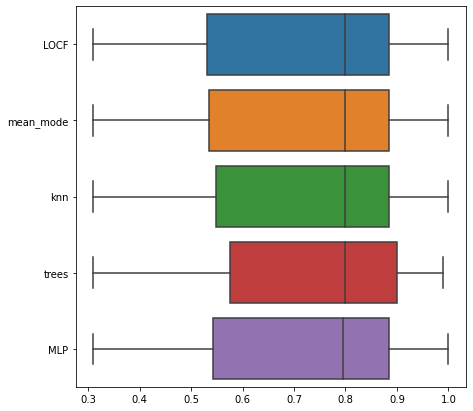

In [34]:
f, ax = plt.subplots(figsize=(7,7))
sns.boxplot(data=df_results,orient="h") #boxplot horizontal

Se puede observar que todos los métodos tienen una variación entre 0.3 y 1. Además, aparentemente el método de imputación basado en arboles de decisión fue un poco mejor. 

## Checamos normalidad:

In [39]:
#checa normalidad univariada
methods=df_results.columns
print('Shapiro test:')
for method in methods:
    W,p_v=stats.shapiro(df_results[method].values) #W>0.9 or p_v>0.05  Normalidad univariada 
    print('Method: '+method+' W: '+str(np.round(W,3))+' p_v: '+str(np.round(p_v,3)))

Shapiro test:
Method: LOCF W: 0.889 p_v: 0.005
Method: mean_mode W: 0.898 p_v: 0.007
Method: knn W: 0.891 p_v: 0.005
Method: trees W: 0.892 p_v: 0.006
Method: MLP W: 0.893 p_v: 0.006


Se rechaza la normalidad y la aproximamos por la transformación Box-Cox:

In [42]:
#aproximar a normal
pt1 = PowerTransformer(method='box-cox') #‘yeo-johnson’ boxcox solo positivos
pt1.fit(df_results.values) #estima los lambdas optimos para la transformacion
X_t=pt1.transform(df_results.values) #aplica la transformacion a los datos
df_results_norm=pd.DataFrame(X_t)
df_results_norm.columns=methods

In [53]:
#checa normalidad univariada
methods=df_results.columns
print('Shapiro test:')
for method in methods:
    W,p_v=stats.shapiro(df_results_norm[method].values) #W>0.9 or p_v>0.05  Normalidad univariada 
    print('Method: '+method+' W: '+str(np.round(W,3))+' p_v: '+str(np.round(p_v,3)))

Shapiro test:
Method: LOCF W: 0.91 p_v: 0.014
Method: mean_mode W: 0.917 p_v: 0.022
Method: knn W: 0.914 p_v: 0.019
Method: trees W: 0.919 p_v: 0.025
Method: MLP W: 0.914 p_v: 0.018


Aceptamos el supuesto de normalidad

## t-test para diferencia en medias al 5%: 

${H_0}:{\mu _1} - {\mu _2} = 0$


In [55]:
print('t-test para diferencia en medias al 5%:')
for method1 in methods:
    for method2 in methods:
        _,pvalue=stats.ttest_ind(df_results_norm[method1].values,df_results_norm[method2].values)
        print(method1+'-'+method2+' acepta H0 :'+str(np.round(pvalue,3)>0.05))

t-test para diferencia en medias al 5%:
LOCF-LOCF acepta H0 :True
LOCF-mean_mode acepta H0 :True
LOCF-knn acepta H0 :True
LOCF-trees acepta H0 :True
LOCF-MLP acepta H0 :True
mean_mode-LOCF acepta H0 :True
mean_mode-mean_mode acepta H0 :True
mean_mode-knn acepta H0 :True
mean_mode-trees acepta H0 :True
mean_mode-MLP acepta H0 :True
knn-LOCF acepta H0 :True
knn-mean_mode acepta H0 :True
knn-knn acepta H0 :True
knn-trees acepta H0 :True
knn-MLP acepta H0 :True
trees-LOCF acepta H0 :True
trees-mean_mode acepta H0 :True
trees-knn acepta H0 :True
trees-trees acepta H0 :True
trees-MLP acepta H0 :True
MLP-LOCF acepta H0 :True
MLP-mean_mode acepta H0 :True
MLP-knn acepta H0 :True
MLP-trees acepta H0 :True
MLP-MLP acepta H0 :True


Para este experimento, ningún método resultó significativamente diferente a otro

## Resultados:

- En este experimento se utilizó la métrica de accuracy con validación cruzada para la tarea de clasificación con 3 modelos de aprendizaje maquina (vecinos mas cercanos, arboles de decisión, y redes neuronales) para 10 conjuntos de datos con valores faltantes con diferentes características (numero de ejemplos, clases, porcentaje de valores faltantes) para los cuales se emplearon 5 métodos diferentes de imputación de datos (no estadísticos, estadísticos y de aprendizaje maquina) con los cuales se obtuvieron 30   observaciones para cada uno de los métodos de imputación.

- Los resultados para todos los métodos variaron en el rango de 0.3 a 1 significando un mal ajuste o sobre ajuste de los modelos. Esto era de esperarse porque no se ajustó un modelo especifico para cada tarea de clasificación, sino que fueron los mismos modelos para cada conjunto de datos, además cada conjunto de datos tenia diferentes numero de clases y en algunos casos desbalanceadas o el tamaño de la muestra muy pequeño como para entrenar bien los modelos.

- A pesar de lo anterior el análisis descriptivo parece mostrar una ligera diferencia en el método de árboles de decisión sobre los demás, aunque el t-test no mostró que esta diferencia sea significativa, por lo que se puede concluir que para este experimento en particular bajo las condiciones descritas ninguno de los métodos de clasificación resultó ser significativamente mejor que los demás, sin embargo quizá si creamos más muestras bajo otras condiciones, por ejemplo si se ajustan modelos específicos para cada caso y utilizamos mas conjuntos de datos podríamos encontrar diferencias significativas en alguno de los métodos.

- Por otro lado, también, para cada conjunto de datos se tendría que hacer un análisis más específico sobre la naturaleza de las variables y del problema para determinar el mejor método de imputación de datos.
